In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os.path
import os
%matplotlib inline

## Helper funcitons

In [2]:
imagepoints_file = "imagepoints.p"
calibration_file = "calibration.p"

test_image_path_white = "test_images/straight_lines2.jpg"
test_image_path_yellow = "test_images/test4.jpg"
test_image_path = test_image_path_white

def is_camera_calibrated():
    return os.path.isfile(calibration_file)

demo_mode = True
cb_cols = 9
cb_rows = 6
    

## Calibration

In [3]:
def get_points():
    fig, cells = plt.subplots(4,5, figsize=(30, 30))
    # fig.subplots_adjust(hspace = .2, wspace=.001)
    cells = cells.ravel()

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    print("Found", len(images), "images:", images)

    # Step through the list and search for chessboard corners
    for cnt, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        cells[cnt].imshow(img)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (cb_cols, cb_rows),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cells[cnt].axis('off')
            cells[cnt].imshow(img)
        else:
            print("Did not find corners for", fname)
            cells[cnt].imshow(img)

    cv2.destroyAllWindows()
   
    dist_pickle = {}
    dist_pickle["objpoints"] = objpoints
    dist_pickle["imgpoints"] = imgpoints
    pickle.dump( dist_pickle, open(imagepoints_file, "wb" ) )

    
def correct_distortion():
    # # Read in the saved objpoints and imgpoints
    dist_pickle = pickle.load( open( imagepoints_file, "rb" ) )
    objpoints = dist_pickle["objpoints"]
    imgpoints = dist_pickle["imgpoints"]

    img = cv2.imread('camera_cal/calibration3.jpg')

    def cal_undistort(img, objpoints, imgpoints):
        img_size = (img.shape[1], img.shape[0])
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        dst = cv2.undistort(img, mtx, dist, None, mtx)

        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump( dist_pickle, open(calibration_file, "wb" ) )

        return dst

    undistorted = cal_undistort(img, objpoints, imgpoints)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

if not is_camera_calibrated():
    print("Calibrating the camera...")
    get_points()
    correct_distortion()
else:
    print("Camera already calibrated, so moving on.")

Camera already calibrated, so moving on.


## Example of undistorted image

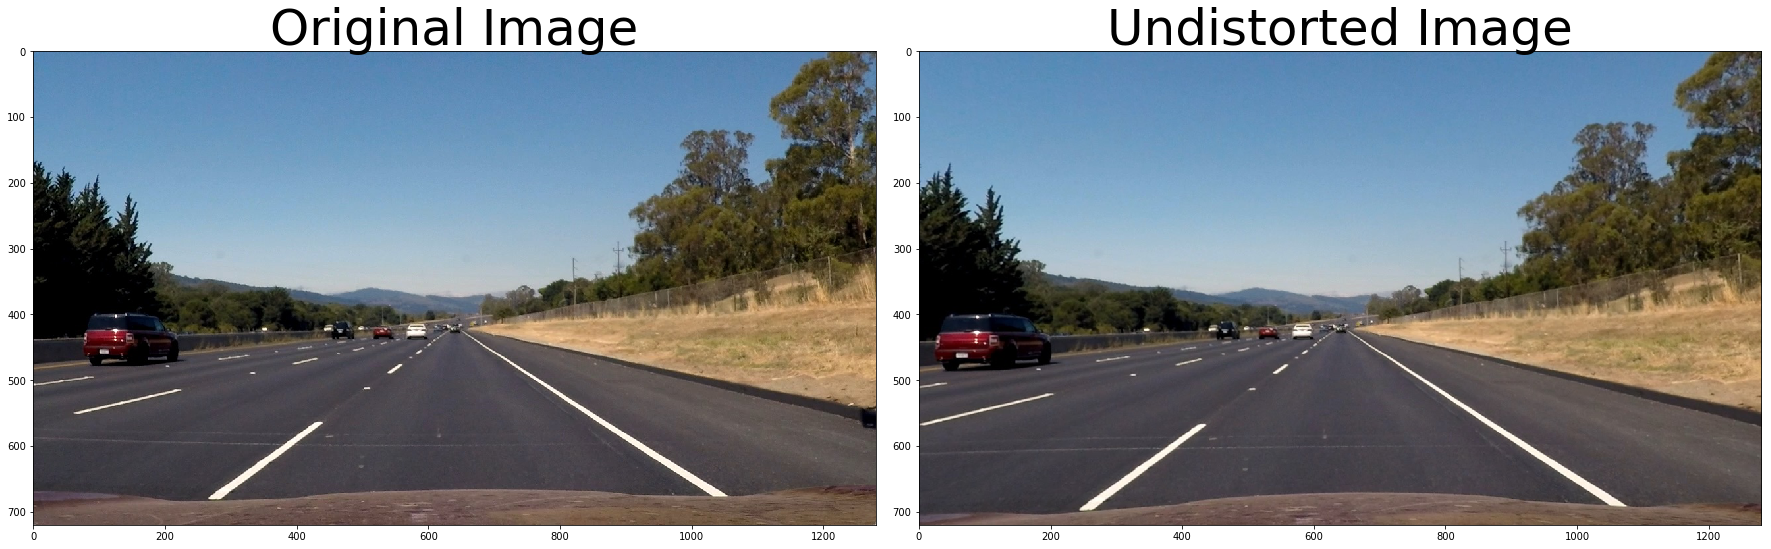

In [4]:
if demo_mode:
    dist_pickle = pickle.load( open( calibration_file, "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    img = cv2.imread(test_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = undistort(img, mtx, dist)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Unwrapping

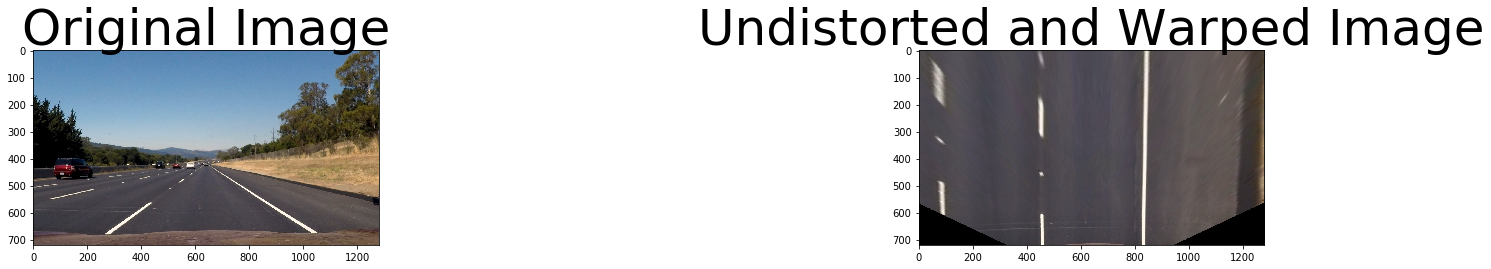

In [5]:

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( calibration_file, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# # Read in an image
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# nx = 8 # the number of inside corners in x
# ny = 6 # the number of inside corners in y

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    h,w = img.shape[:2]
    
    # NEED BETTER POINTS - USE IMAGE WITH STRAIGHT LINES TO DEFINE TRAPEZOID
    
#     psrc = np.float32([(580,464),
#                       (725,464), 
#                       (310,682), 
#                       (1100,682)])
#     pdst = np.float32([(450,0),
#                       (w-450,0),
#                       (450,h),
#                       (w-450,h)])
    
    psrc = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
    pdst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

    M = cv2.getPerspectiveTransform(psrc,pdst)
    warped = cv2.warpPerspective(dst, M, (w,h), flags=cv2.INTER_LINEAR)

    return warped, M


# cv2.line(img, (580, 464),(725,464),(200,255,155), 5)
# cv2.line(img, (725, 464),(1100,682),(200,255,155), 5)
# cv2.line(img, (1100, 682),(310,682),(200,255,155), 5)
# cv2.line(img, (310, 682),(580,464),(200,255,155), 5)

top_down, perspective_M = corners_unwarp(img, cb_cols, cb_rows, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 3))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Gradients

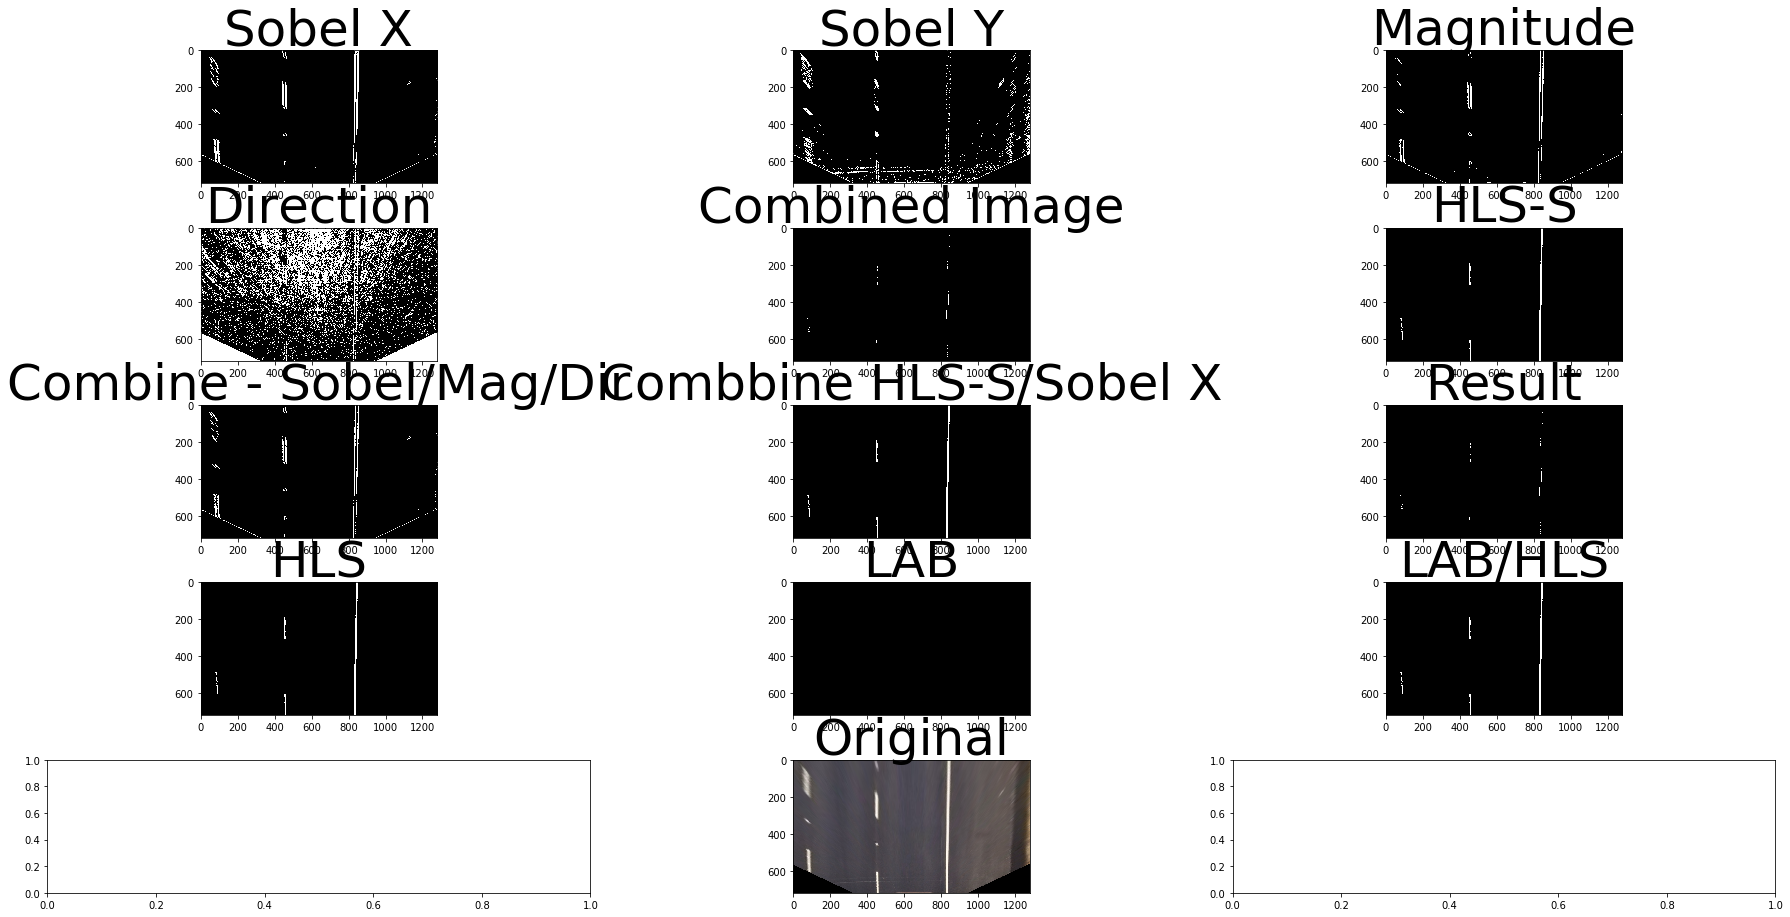

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(220, 255)):
#     hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#     s_channel = hls[:,:,1]
#     s_channel = s_channel*(255/np.max(s_channel))
#     binary_output = np.zeros_like(s_channel)
#     binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
#     return binary_output
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

if demo_mode:
    # img_LThresh = hls_lthresh(img_unwarp)

    # # Lab B-channel Threshold (using default parameters)
    # img_BThresh = lab_bthresh(img_unwarp)

    # # Combine HLS and Lab B channel thresholds
    # combined = np.zeros_like(img_BThresh)
    # combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1

    top_down_hls = hls_select(top_down)
    top_down_lab = lab_bthresh(top_down)
    lab_hls = np.zeros_like(top_down_lab)
    lab_hls[(top_down_hls == 1) | (top_down_lab == 1)] = 1

    top_down_gs = top_down #cv2.cvtColor(top_down,cv2.COLOR_BGR2RGB)

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(top_down_gs, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(top_down_gs, orient='y', sobel_kernel=ksize, thresh=(5, 255))
    mag_binary = mag_thresh(top_down_gs, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(top_down, sobel_kernel=ksize, thresh=(0, 0.1))
    # dir_min_thresh=(0,np.pi/2,0.01), 
    #                  dir_max_thresh=(0,np.pi/2,0.01))

    combined_sobel_dirmag = np.zeros_like(dir_binary)
    combined_sobel_dirmag[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    combined_hls_sobelx = np.zeros_like(dir_binary)
    combined_hls_sobelx[((gradx == 1) & (top_down_hls == 1))] = 1

    combined = np.zeros_like(dir_binary)
    combined[((combined_hls_sobelx == 1) & (combined_sobel_dirmag == 1))] = 1

    f, axes = plt.subplots(5, 3, figsize=(24, 9))
    f.tight_layout()

    axes[0,0].imshow(gradx, cmap='gray')
    axes[0,0].set_title('Sobel X', fontsize=50)

    axes[0,1].imshow(grady, cmap='gray')
    axes[0,1].set_title('Sobel Y', fontsize=50)

    axes[0,2].imshow(mag_binary, cmap='gray')
    axes[0,2].set_title('Magnitude', fontsize=50)

    axes[1,0].imshow(dir_binary, cmap='gray')
    axes[1,0].set_title('Direction', fontsize=50)

    axes[1,1].imshow(combined, cmap='gray')
    axes[1,1].set_title('Combined Image', fontsize=50)

    axes[1,2].imshow(top_down_hls, cmap='gray')
    axes[1,2].set_title('HLS-S', fontsize=50)

    axes[2,0].imshow(combined_sobel_dirmag, cmap='gray')
    axes[2,0].set_title('Combine - Sobel/Mag/Dir', fontsize=50)

    axes[2,1].imshow(top_down_hls, cmap='gray')
    axes[2,1].set_title('Combbine HLS-S/Sobel X', fontsize=50)

    axes[2,2].imshow(combined, cmap='gray')
    axes[2,2].set_title('Result', fontsize=50)

    axes[3,0].imshow(top_down_hls, cmap='gray')
    axes[3,0].set_title('HLS', fontsize=50)

    axes[3,1].imshow(top_down_lab, cmap='gray')
    axes[3,1].set_title('LAB', fontsize=50)

    axes[3,2].imshow(lab_hls, cmap='gray')
    axes[3,2].set_title('LAB/HLS', fontsize=50)

    axes[4,1].imshow(top_down)
    axes[4,1].set_title('Original', fontsize=50)

    plt.subplots_adjust(left=0., right=1, top=1.3, bottom=0.)

## Combine gradient and color transformation

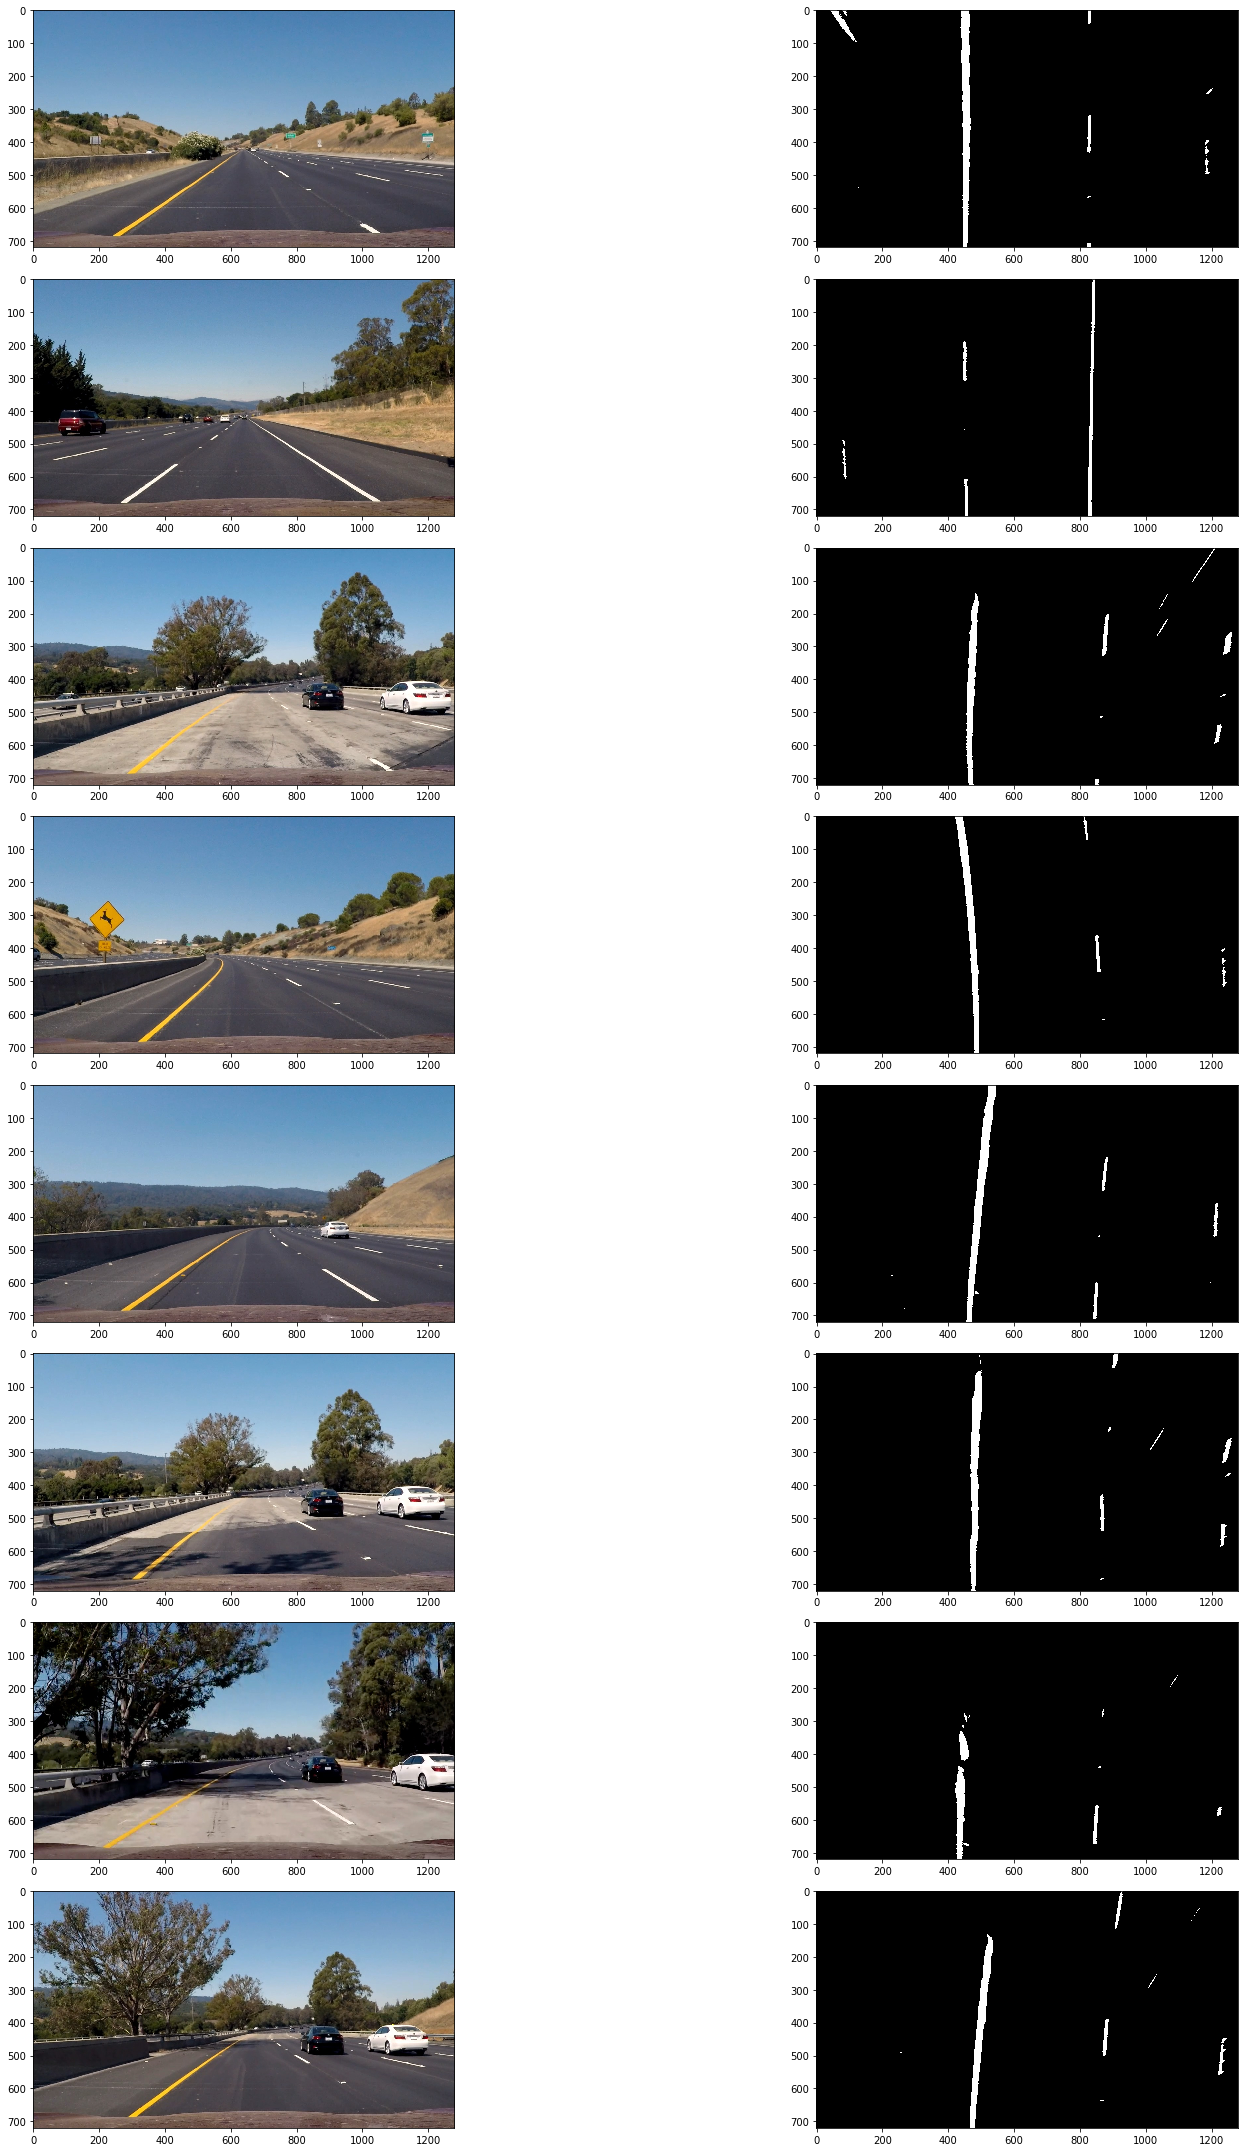

In [8]:
def apply_gradient_and_color(img):
    top_down_hls = hls_select(img)
    top_down_lab = lab_bthresh(img)
    lab_hls = np.zeros_like(top_down_lab)
    lab_hls[(top_down_hls == 1) | (top_down_lab == 1)] = 1
    return lab_hls

def pipeline(img):
    unwarped, perspective_M = corners_unwarp(img, cb_cols, cb_rows, mtx, dist)
    binary = apply_gradient_and_color(unwarped)
    return binary

def pipeline_f(fname):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    binary = pipeline(gray)
    return binary

if demo_mode:
    fig, cells = plt.subplots(8, 2, figsize=(30, 30))
    plt.tight_layout()
    cells = cells.ravel()
    images = glob.glob('test_images/*.jpg')

    for cnt, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        binary = pipeline(gray)
        cells[cnt * 2].imshow(gray, cmap='gray')
        cells[cnt * 2 + 1].imshow(binary, cmap='gray')

    fig.tight_layout()

## Lane line identification

### Histogram test

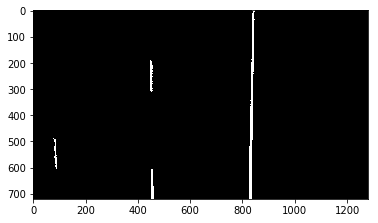

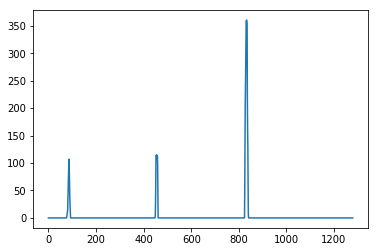

In [9]:
img = pipeline_f("test_images/straight_lines2.jpg")
imgplot = plt.imshow(img, cmap="gray")
plt.show()

histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [26]:
binary_warped = img
print(binary_warped.shape)
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
# histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 1280)
(array([  0,   0,   0, ..., 719, 719, 719], dtype=int64), array([838, 839, 840, ..., 833, 834, 835], dtype=int64))


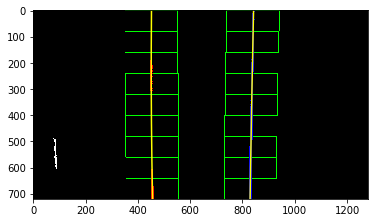

In [23]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)
# plt.imshow(img)
